In [10]:
import pandas as pd

data = pd.read_parquet('announcement/processed_LLM_data_test_3_10_30_2k_summary.parquet')
data

,symbol,time,content,log_r
489,600031.SH,2023-04-14 09:00:00,现在是2023-04-14 09:00:00+08:00\n时间：2023-04-04 16...,0.011628
490,600031.SH,2023-04-25 09:00:00,现在是2023-04-25 09:00:00+08:00\n时间：2023-04-09 17...,0.009274
491,600031.SH,2023-04-25 09:00:00,现在是2023-04-25 09:00:00+08:00\n时间：2023-04-09 17...,0.009274
492,600031.SH,2023-04-26 09:00:00,现在是2023-04-26 09:00:00+08:00\n时间：2023-04-10 18...,0.015323
493,600031.SH,2023-04-26 09:00:00,现在是2023-04-26 09:00:00+08:00\n时间：2023-04-13 23...,0.015323
...,...,...,...,...
6482,601668.SH,2024-03-21 09:00:00,现在是2024-03-21 09:00:00+08:00\n时间：2024-02-26 18...,-0.005764
6483,601668.SH,2024-03-21 09:00:00,现在是2024-03-21 09:00:00+08:00\n时间：2024-03-15 18...,-0.005764
6484,601668.SH,2024-03-25 09:00:00,现在是2024-03-25 09:00:00+08:00\n时间：2024-03-15 18...,0.009625
6485,601668.SH,2024-03-29 09:00:00,现在是2024-03-29 09:00:00+08:00\n时间：2024-03-20 19...,0.000000


In [11]:
print(data['log_r'].min())
print(data['log_r'].max())

-0.14738339987986324
0.19597357113544278


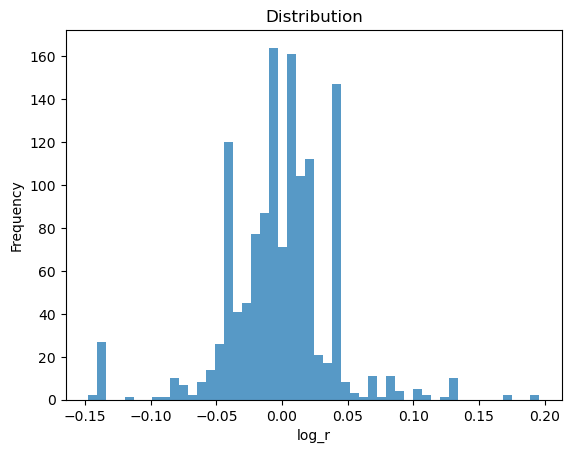

sigma: 0.04, mean: -0.001, variance: 0.002


In [12]:
import matplotlib.pyplot as plt

plt.hist(data['log_r'], bins=50, alpha=0.75)
plt.title('Distribution')
plt.xlabel('log_r')
plt.ylabel('Frequency')
plt.show()

sigma = round(data['log_r'].std(), 3)
mean = round(data['log_r'].mean(), 3)
variance = round(data['log_r'].var(), 3)

print(f'sigma: {sigma}, mean: {mean}, variance: {variance}')

In [13]:
data['label'], bins = pd.qcut(data['log_r'], 5, labels=False, retbins=True)

# Printing if there are any null values in 'log_r'
print(data['log_r'].isnull().any())

# Printing the rows where 'log_r' is null
print(data[data['log_r'].isnull()])

# Printing the bin ranges
print("Bin ranges:")
for i in range(len(bins) - 1):
    print(f"Bin {i}: {bins[i]} to {bins[i + 1]}")

True
         symbol                time  \
568   600031.SH 2024-04-12 09:00:00   
569   600031.SH 2024-04-12 09:00:00   
1650  600050.SH 2024-04-11 09:00:00   
1651  600050.SH 2024-04-11 09:00:00   
1652  600050.SH 2024-04-11 09:00:00   
...         ...                 ...   
5874  603160.SH 2024-04-11 09:00:00   
5875  603160.SH 2024-04-11 09:00:00   
5876  603160.SH 2024-04-11 09:00:00   
5877  603160.SH 2024-04-11 09:00:00   
6486  601668.SH 2024-04-12 09:00:00   

                                                content  log_r  label  
568   现在是2024-04-12 09:00:00+08:00\n时间：2024-04-03 18...    NaN    NaN  
569   现在是2024-04-12 09:00:00+08:00\n时间：2024-04-03 18...    NaN    NaN  
1650  现在是2024-04-11 09:00:00+08:00\n时间：2024-03-19 19...    NaN    NaN  
1651  现在是2024-04-11 09:00:00+08:00\n时间：2024-03-19 19...    NaN    NaN  
1652  现在是2024-04-11 09:00:00+08:00\n时间：2024-03-19 19...    NaN    NaN  
...                                                 ...    ...    ...  
5874  现在是2024-04-11 09

In [14]:
data['label']

489     3.0
490     3.0
491     3.0
492     3.0
493     3.0
       ... 
6482    2.0
6483    2.0
6484    3.0
6485    2.0
6486    NaN
Name: label, Length: 1400, dtype: float64

In [15]:
import pandas as pd
import json
from tqdm import tqdm
from transformers import AutoTokenizer
from concurrent.futures import ThreadPoolExecutor


def process_row(row):
    try:
        stock_mapping = {
            "600031.SH": "三一重工",
            "600036.SH": "招商银行",
            "600050.SH": "中国联通",
            "600104.SH": "上汽集团",
            "600346.SH": "恒力石化",
            "600570.SH": "恒生电子",
            "600887.SH": "伊利股份",
            "601390.SH": "中国中铁",
            "603160.SH": "汇项科技",
            "601668.SH": "中国建筑"
        }
        stock = stock_mapping[row['symbol']]
        prompt = f"请根据以下新闻文本，预测{stock}股票的对数收益率属于以下哪一类别 (极度负面/负面/中性/正面/极度正面)"
        label_mapping = {0: "极度负面", 1: "负面", 2: "中性", 3: "正面", 4: "极度正面"}
        label = label_mapping[row['label']]

        # def calculate_token_length(text):
        #     model_name = "/home/zhangmin/.cache/modelscope/hub/qwen/Qwen-7B-Chat"
        #     tokenizer = AutoTokenizer.from_pretrained(model_name,  trust_remote_code=True)
        #     tokens = tokenizer.encode(text, truncation=True)
        #     return len(tokens)

        # token = calculate_token_length(row['content'])

        return {
            "prompt": prompt,
            "content": row['content'],
            "label": label,
            # "token": token
        }
    except Exception as e:
        print(f"Error processing row: {e}")
        return None


def generate_dataset(df, max_samples=32):
    df_subset = df.head(max_samples)
    results = []
    with ThreadPoolExecutor(max_workers=50) as executor:
        futures = [executor.submit(process_row, row) for _, row in df_subset.iterrows()]
        for future in tqdm(futures, total=len(futures), desc="Processing rows"):
            result = future.result()
            if result:
                results.append(result)

    return results


# processed_data = [process_row(row) for _, row in tqdm(data.iterrows(), total=data.shape[0]) if process_row(row) is not None]
processed_data = generate_dataset(data, max_samples=1000000)
output_file_path = 'ft_data_summary_2k_test_3.json'
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

Error processing row: nanError processing row: nan

Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error processing row: nan
Error proces

Processing rows: 100%|██████████| 1400/1400 [00:00<00:00, 401918.25it/s]


In [16]:
# from sklearn.model_selection import train_test_split

# train_data, test_data = train_test_split(processed_data, test_size=0.1, random_state=42)

# train_file_path = 'ft_data_32k/train.json'
# test_file_path = 'ft_data_32k/test.json'

# with open(train_file_path, 'w', encoding='utf-8') as f:
#     json.dump(train_data, f, ensure_ascii=False, indent=2)

# with open(test_file_path, 'w', encoding='utf-8') as f:
#     json.dump(test_data, f, ensure_ascii=False, indent=2)

In [17]:
# import json

# with open('ft_data.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# count = sum(1 for d in data if d['token'] >= 8192)
# print(f"The number of data with token length greater than 8192 is: {count}")

In [18]:
# import json
# from sklearn.model_selection import train_test_split

# with open('ft_data_summary_2k_train_3.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
# with open('ft_data_summary_2k/train.json', 'w', encoding='utf-8') as f:
#     json.dump(train_data, f, ensure_ascii=False, indent=4)
# with open('ft_data_summary_2k/test.json', 'w', encoding='utf-8') as f:
#     json.dump(test_data, f, ensure_ascii=False, indent=4)